In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [4]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set to length 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0


## Read in test data

In [5]:
# set up test set
test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)
print(test_v.shape)
print(test_df.columns.get_loc('TCHDL'))

Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096
(282688, 182)
14


## Set up x and y

In [6]:
print('AGE:', view_1hot_df.columns.get_loc('AGE'))
print('NZDEP:', view_1hot_df.columns.get_loc('NZDEP'))
print('ETHN_1:', view_1hot_df.columns.get_loc('ETHN_1'))
print('ETHN_5:', view_1hot_df.columns.get_loc('ETHN_5'))
print('TEST:', view_1hot_df.columns.get_loc('TEST'))
print('HDL:', view_1hot_df.columns.get_loc('HDL'))
print('LDL:', view_1hot_df.columns.get_loc('LDL'))
print('TRI:', view_1hot_df.columns.get_loc('TRI'))
print('TCL:', view_1hot_df.columns.get_loc('TCL'))
print('TCHDL:', view_1hot_df.columns.get_loc('TCHDL'))
print('TESTED:', view_1hot_df.columns.get_loc('TESTED'))
print('DIED:', view_1hot_df.columns.get_loc('DIED'))
print('############# PHARMS ##############')
print('LL_SIMVASTATIN:', view_1hot_df.columns.get_loc('LL_SIMVASTATIN'))
print('LL_PDC:', view_1hot_df.columns.get_loc('LL_PDC'))
print('CVD_FELODIPINE:', view_1hot_df.columns.get_loc('CVD_FELODIPINE'))
print('CVD_HYDROCHLOROTHIAZIDE:', view_1hot_df.columns.get_loc('CVD_HYDROCHLOROTHIAZIDE'))
print('OTHER_TENOXICAM:', view_1hot_df.columns.get_loc('OTHER_TENOXICAM'))
print('OTHER_VILDAGLIPTIN:', view_1hot_df.columns.get_loc('OTHER_VILDAGLIPTIN'))
print('############# NMDS ##############')
print('NUMBER_OF_DAYS:', view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print('hx_broad_cvd:', view_1hot_df.columns.get_loc('hx_broad_cvd'))
print('out_atrial_fibrillation:', view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print('############# HbA1c, GFR and PT ##############')
print('HBA1C:', view_1hot_df.columns.get_loc('HBA1C'))
print('TEST_HBA1C:', view_1hot_df.columns.get_loc('TEST_HBA1C'))
print('TESTED_HBA1c:', view_1hot_df.columns.get_loc('TESTED_HBA1C'))
print('EGFR:', view_1hot_df.columns.get_loc('EGFR'))
print('TEST_EGFR:',view_1hot_df.columns.get_loc('TEST_EGFR'))
print('TESTED_EGFR:', view_1hot_df.columns.get_loc('TESTED_EGFR'))
print('PT_SBP:', view_1hot_df.columns.get_loc('PT_SBP'))
print('PT_DIABETES_YR:', view_1hot_df.columns.get_loc('PT_DIABETES_YR'))
print('PT_ATRIAL_FIBRILLATION:', view_1hot_df.columns.get_loc('PT_ATRIAL_FIBRILLATION'))
print('PT_IMP_FATAL_CVD:', view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

AGE: 1
NZDEP: 3
ETHN_1: 4
ETHN_5: 8
TEST: 9
HDL: 10
LDL: 11
TRI: 12
TCL: 13
TCHDL: 14
TESTED: 15
DIED: 16
############# PHARMS ##############
LL_SIMVASTATIN: 17
LL_PDC: 28
CVD_FELODIPINE: 29
CVD_HYDROCHLOROTHIAZIDE: 81
OTHER_TENOXICAM: 82
OTHER_VILDAGLIPTIN: 119
############# NMDS ##############
NUMBER_OF_DAYS: 120
hx_broad_cvd: 122
out_atrial_fibrillation: 162
############# HbA1c, GFR and PT ##############
HBA1C: 163
TEST_HBA1C: 164
TESTED_HBA1c: 165
EGFR: 166
TEST_EGFR: 167
TESTED_EGFR: 168
PT_SBP: 169
PT_DIABETES_YR: 179
PT_ATRIAL_FIBRILLATION: 180
PT_IMP_FATAL_CVD: 181


In [7]:
def set_up_xy(time_series):
    num_of_inds = time_series.shape[0]//28
    n_features = time_series.shape[1]
    
    _x = np.empty((num_of_inds, 
                   n_features+(n_features-1)*7), 
                   dtype='float')
    _y = np.empty((num_of_inds, 20), dtype='float') # 3, 
    ###############################################
    # construct x and y  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        ind_v = copy.deepcopy(time_series[(i*28):((i+1)*28), :])
        _x[i, :n_features] = copy.deepcopy(ind_v[0, :])
        for j in range(1, 8):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(ind_v[j, 1:])
        _y[i, :] = ind_v[8:28, 14]
    return _x, _y

In [8]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 
scaled_test = scaler.transform(test_v)
x_train, y_train = set_up_xy(scaled_train)
x_test, y_test = set_up_xy(scaled_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(90000, 1449)
(90000, 20)
(10096, 1449)
(10096, 20)


In [9]:
def set_up_model(n_units, dropout_rate_1, dropout_rate_2):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', 
                    input_shape=(1449, ))) 
    model.add(Dropout(dropout_rate_1))
    model.add(Dense(n_units, activation='relu'))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(20, activation='linear')) #20
    model.compile(loss='mae', optimizer='adam')
    return model

In [10]:
def fit_model(model, X_train, Y_train, b_size):
    val_weight = "MLP_val_weights.hdf5"
    val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                         monitor='val_loss', verbose=1,
                                         save_best_only=True)
    history = model.fit(X_train, Y_train,
                        batch_size=b_size, 
                        epochs=50, 
                        validation_split=0.1, 
                        callbacks=[val_checkpointer], 
                        verbose=2, 
                        shuffle=False)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    val_loss = min(history.history['val_loss'])
    return val_loss, val_weight

9000
End: 9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 2s - loss: 0.5139 - val_loss: 0.4612

Epoch 00001: val_loss improved from inf to 0.46124, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4634 - val_loss: 0.4520

Epoch 00002: val_loss improved from 0.46124 to 0.45201, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4547 - val_loss: 0.4476

Epoch 00003: val_loss improved from 0.45201 to 0.44760, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4502 - val_loss: 0.4461

Epoch 00004: val_loss improved from 0.44760 to 0.44614, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4464 - val_loss: 0.4454

Epoch 00005: val_loss improved from 0.44614 to 0.44544, saving model to M

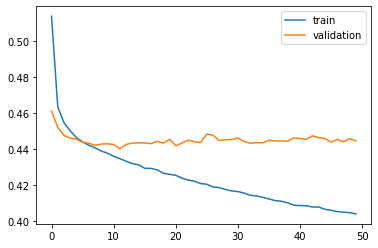

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.4390587181954727
Dropout rate 2: 0.009144138672095903
Fold: 0
Best val loss: 0.44020821844206914
#################################
Time to train MLP:  56.644872188568115
Entire process took:  56.73261380195618
Experiment record:
[[256, 256, 0.4390587181954727, 0.009144138672095903, 0, 0.44020821844206914]]


In [11]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

start_time = time.time()

n_units = 256
b_size = 256
dropout_rate_1 = 0.4390587181954727
dropout_rate_2 = 0.009144138672095903

exp_record = []

for f in range(1):
    end = int((f+1)*num_per_fold*1)
    print("End:", end)
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_mlp = np.append(train2_x, train1_x, axis=0) 
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_mlp = np.append(train2_y, train1_y, axis=0)

    start_time_inner = time.time()
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = set_up_model(n_units, 
                             dropout_rate_1, 
                             dropout_rate_2)
        val_loss, val_weight = fit_model(model, 
                                         train_x_mlp, 
                                         train_y_mlp, 
                                         b_size)
        print("#################################")
        print("Number of units:", n_units)
        print("Batch size:", b_size)
        print("Dropout rate 1:", dropout_rate_1)
        print("Dropout rate 2:", dropout_rate_2)
        print("Fold:", f)
        print("Best val loss:", val_loss)
        exp_record.append([n_units, b_size, 
                               dropout_rate_1, 
                               dropout_rate_2, 
                               f, val_loss])
        print("#################################")
        model.load_weights(val_weight)
        yhat_test = model.predict(x_test)
        print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [12]:
print(yhat_test.shape)
yhat_v = copy.deepcopy(scaled_test)
for ind in range(yhat_v.shape[0]//28):
    yhat_v[((ind*28)+8):((ind+1)*28), 14] = yhat_test[ind]
inv_yhat_v = scaler.inverse_transform(yhat_v)

(10096, 20)


In [13]:
yhat_df = pd.DataFrame(inv_yhat_v)
yhat_df.columns = list(test_df.columns)[ :-7]
feather.write_dataframe(yhat_df, "/home/whsu014/data/TCHDL_MLP_yhat.feather")